# Purpose
This file is used to build a dataset that includes datasets from different sources. The output is a HuggingFace dataset object.

## Preparation
Before running this notebook some prerequisites must be fulfilled:
    * The Zenodo audiofiles should be in Data/Zenodo
    * The Zenodo annotations.csv should be in Zenodo/

In [1]:
# Installing dependencies
%pip install datasets
%pip install librosa
%pip install -U matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: matplotlib in /home/jlange/.local/lib/python3.8/site-packages (3.7.2)
Note: you may need to restart the kernel to use updated packages.


Change the following variables, if the Data or Annotations folder are not in the same directory as this file.

In [5]:
data_path = "/data-project/DeepBirdDetect/BirdSet/Data/"
annotations_path = "Annotations/"

In [2]:
"""
Build an empty dictionary with the colmun-names as keys. For each dataset (i.e. Zenodo, Oeko4, etc.) the empty_dataset is deepcopied and filled.
The resulting dataset can then be converted into a HuggingFace Dataset object.
Also build dictionarys to translate different bird-codes
"""
import copy
datasets = []
columns=["ID", "Audio", "Start Time (s)", "End Time (s)", "Low Freq (Hz)", "High Freq (Hz)", "Species eBird Code"
         , "Call Type", "Sex", "Latitude", "Longitude", "Uncertainty", "Microphone", "License", "Source"
         , "BirdNet Training Data"]
empty_dataset = {}
for column in columns:
    empty_dataset[column]=[]    

"""
Read the taxonomy from the csv file and convert it to the e_bird_codes dictionary.
common_to_ebird maps common_names to e-bird-codes
"""
import csv
common_to_ebird = {} #This dict saves the e-bird-code for each common name
with open('ebird_taxonomy_v2022.csv', newline='') as csvfile:
    taxonomy = csv.reader(csvfile, delimiter=',', quotechar='|')
    first = True
    for row in taxonomy:
        if first:
            first = False
            continue
        common_name = row[3]
        e_bird_code = row[2]
        common_to_ebird[common_name]=e_bird_code

"""
The sci_to_ebird dictionary maps each scientific (latin) name to the corresponding e-bird-code.
"""
import csv
sci_to_ebird = {} #This dict saves the e-bird-code for each common name
with open('ebird_taxonomy_v2022.csv', newline='') as csvfile:
    taxonomy = csv.reader(csvfile, delimiter=',', quotechar='|')
    first = True
    for row in taxonomy:
        if first:
            first = False
            continue
        sci_name = row[4]
        e_bird_code = row[2]
        sci_to_ebird[sci_name]=e_bird_code

"""
The ebird_to_common dictionary maps each e-bird-code to the corresponding common name.
"""
ebird_to_common = {} #This dict saves the e-bird-code for each common name
with open('ebird_taxonomy_v2022.csv', newline='') as csvfile:
    taxonomy = csv.reader(csvfile, delimiter=',', quotechar='|')
    first = True
    for row in taxonomy:
        if first:
            first = False
            continue
        common_name = row[3]
        e_bird_code = row[2]
        ebird_to_common[e_bird_code]=common_name



"""
The alpha_to_ebird dictionary maps each alpha-code to the corresponding ebird-code.
"""
alpha_to_ebird = {} #This dict saves the alpha-code for each e_bird_code
not_found = []
with open('AlphaCodes.csv', newline='') as csvfile:
    taxonomy = csv.reader(csvfile, delimiter=',', quotechar='|')
    first = True
    for row in taxonomy:
        if first:
            first = False
            continue
        common_name = row[3]
        alpha_code = row[1]
        sci_name = row[4]
        if common_name in common_to_ebird.keys():
            alpha_to_ebird[alpha_code]=common_to_ebird[common_name]
        elif sci_name in sci_to_ebird.keys():
            #Sometimes different common names are used
            alpha_to_ebird[alpha_code]=sci_to_ebird[sci_name]
        else:
            not_found.append(f"{common_name}/ {sci_name}")
print(f"There are {len(not_found)} out of {len(not_found)+len(alpha_to_ebird.keys())} entrys in the Alpha codes which I could not translate to ebirdcodes")



There are 79 out of 2326 entrys in the Alpha codes which I could not translate to ebirdcodes


## Partial Datasets
First HuggingFace dataset objects are created for each datamodule.

### Zenodo
The following Block builds the Zenodo dataset and adds it to the list of datasets. The Zenodo dataset consists of 5 Datasets, namely HSN, SNE, UHH, PER and SSW. The following block combines these 5 Datasets into a single HuggingFace Dataset object.

#### Define Constants
The following codeblock defines some required constants. These include the folder names for the 5 Datasets, their respective sources, as well as their respective cooridinates (Latitude, Longitude).

In [3]:
subsets = ["HSN", "SNE", "UHH", "PER", "SSW", "NES"]

sources={"HSN": "https://zenodo.org/record/7525805",
        "SNE": "https://zenodo.org/record/7050014",
        "UHH": "https://zenodo.org/record/7078499",
        "PER": "https://zenodo.org/record/7079124",
        "SSW": "https://zenodo.org/record/7079380",
        "NES": "https://zenodo.org/record/7525349"}
"""
Coordinates are saved as [latitude, logitude]. Some of the datasets contain multiple recording sights.
I filled these in by hand, as the different datasets had used different formats which had to be 
converted to (Lat,Lon).
"""
coordinates={"HSN": {0:[37.0, -118.5]},
             "SNE": {0:[38.49, -119.95]},
             "UHH": {1:[19.801668, -155.609444],
                     2:[19.792975, -155.321332],
                     3:[19.46647, -155.582011],
                     4:[19.820609, -155.468097]},
             "PER": {1:[-12.542578, -69.062050],
                     2:[-12.541925, -69.058642],
                     4:[-12.537814, -69.054308],
                     5:[-12.535539, -69.06674],
                     6:[-12.532981, -69.049864],
                     8:[-12.529858, -69.046164],
                     10:[-12.522983, -69.046822]},
             "SSW": {0:[42.4768, -76.4527]},
             "NES": {1:[5.59,-75.85],
                     2:[10.11,-84.52]}
} 

#### Build Dataset
The following block builds a dictionary from the data and converts it into a HuggingFace Dataset Object

In [8]:
import csv
from datasets import Audio, Dataset

#build the dictionary
#deepcopy is necessary here, because otherwise the empty_dataset gets changed
dict = copy.deepcopy(empty_dataset)
ID=0
for subset in subsets:
    with open(f'{annotations_path}Zenodo/{subset}_annotations.csv', newline='') as annotations:
        reader = csv.DictReader(annotations) 
        for sample in reader:
            #filter out unknown birds (in the case of zenodo these are all marked as ????)
            if sample["Species eBird Code"] == "????":
                continue

            dict["ID"].append(str(ID))
            dict["Audio"].append(f"{data_path}Zenodo/{sample['Filename']}")     
            dict["Start Time (s)"].append(sample["Start Time (s)"])
            dict["End Time (s)"].append(sample["End Time (s)"])
            dict["Low Freq (Hz)"].append(sample["Low Freq (Hz)"])
            dict["High Freq (Hz)"].append(sample["High Freq (Hz)"])
            dict["Species eBird Code"].append(sample["Species eBird Code"])
            dict["Call Type"].append(None)
            dict["Sex"].append(None)

            # Some of the subsets used multiple recording sights
            if subset in ["UHH","PER"]:
                #This part of the filename denotes the Recording Sight
                sight = int(sample['Filename'][9:11])
            else:
                sight = 0
            dict["Latitude"].append(coordinates[subset][sight][0])
            dict["Longitude"].append(coordinates[subset][sight][1])

            dict["Uncertainty"].append(None)
            dict["Microphone"].append("Soundscape")
            dict["License"].append("Creative Commons Attribution 4.0 International Public License")
            dict["Source"].append(sources[subset])
            
            # We do not know that yet
            dict["BirdNet Training Data"].append(None)
            ID += 1

#The following line is only used to extract metadata later
zenodo = copy.deepcopy(dict)

#Convert the dictionary into a HuggingFace Dataset object
audio_dataset = Dataset.from_dict(dict).cast_column("Audio", Audio())
datasets.append(audio_dataset)
print(audio_dataset[0]["Audio"])

{'path': '/data-project/DeepBirdDetect/BirdSet/Data/Zenodo/HSN_001_20150708_061805.flac', 'array': array([-0.00073242, -0.00057983, -0.00057983, ..., -0.00030518,
       -0.00048828, -0.00048828]), 'sampling_rate': 32000}


## OekoFor Dataset
For the following code to work properly, all extracted folders should be directly inside Data/OekoFor.
For example:
"Data/OekoFor/2016_Scotland/Goldcrest_c (Kontaktruf)_1_NA_Ralph Martin_160923_07_13_48_GB_FKS_RM_LS_72093_s125.4.wav"

In [9]:
"""
Build the Dictonary
"""
import csv
import os
folders = [name for name in os.listdir(f"{data_path}OekoFor/") if os.path.isdir(f"{data_path}/OekoFor/{name}")]
#build the dictionary
#deepcopy is necessary here, because otherwise the empty_dataset gets changed
dict = copy.deepcopy(empty_dataset)
ID=0
correct = 0
incorrect = 0
other_sounds = 0
# This caharmap is used to exchange all special german charaters (Umlaute)
#special_char_map = {ord('ä'):'ae', ord('ü'):'ue', ord('ö'):'oe', ord('ß'):'ss'}
for folder in folders:
    path = f"{data_path}OekoFor/{folder}/"
    annotations = [name for name in os.listdir(path) if name[-4:] == ".txt"]
    audio_files = [name for name in os.listdir(path) if name[-4:] == ".wav"]
    for annotation_file in annotations:
        with open(f'{path}{annotation_file}', encoding="iso-8859-1", newline='') as annotations:
            reader = csv.DictReader(annotations, delimiter='\t') 
            for sample in reader:            
                #Samples that are incorrect are removed
                if sample["correct"] == "1":
                    correct += 1
                else:
                    #correct == 0
                    incorrect += 1
                    continue #remove this line to include incorrect annotations into the dictionary
                
                #Samples that are not Birds are removed
                bird = sample["common_name"]
                if bird == "Mongolian Gull":
                    #The dataset used a different name here
                    bird = "Herring Gull (Mongolian)"
                if bird in common_to_ebird:
                    bird = common_to_ebird[bird]
                else:
                    other_sounds+=1
                    continue
                
                #For uniformity replace NA and "" with None
                for key in sample.keys():
                    if sample[key] == "NA" or sample[key]=="":
                        sample[key] = None
                    #else:
                    #    sample[key] = sample[key].translate(special_char_map)

                dict["ID"].append(str(ID))
                dict["Audio"].append(f"{path}{annotation_file[:-4]}.wav")     
                dict["Start Time (s)"].append(sample['start_sample_random [s]'])
                dict["End Time (s)"].append(sample['end_sample_random [s]'])
                dict["Low Freq (Hz)"].append(sample['low_freq [Hz]'])
                dict["High Freq (Hz)"].append(sample['high_freq [Hz]'])
                dict["Species eBird Code"].append(bird)
                
                #Sometimes the german umlaut ae is used in the annotations for the call type
                #These german "Umlaute" are removed to avoid trouble
                if sample['call_type'] is None:
                    dict["Call Type"].append(None)
                elif "gelschlag" in  sample['call_type']:
                    dict['Call Type'].append('wb (Fluegelschlag)')
                else:
                    dict["Call Type"].append(sample['call_type'])

                dict["Sex"].append(sample['sex'])

                if sample['latitude [WGS84]'] is None:
                    dict["Latitude"].append(None)
                else:
                    dict["Latitude"].append(float(sample['latitude [WGS84]']))

                if sample['longitude [WGS84]'] is None:
                    dict["Longitude"].append(None)
                else:
                    dict["Longitude"].append(float(sample['longitude [WGS84]']))

                if sample['uncertainty of GPS data [km]'] is None:
                    dict["Uncertainty"].append(None)
                else:
                    dict["Uncertainty"].append(float(sample['uncertainty of GPS data [km]']))

                dict["Microphone"].append("Soundscape")
                dict["License"].append("Unknown")
                dict["Source"].append(f"https://cornell.box.com/s/8cpulu253x6kfnc6wag3uovi9p9eb98h {folder}")
                
                # We do not know that yet
                dict["BirdNet Training Data"].append(False)
                ID += 1
print(f"There are {correct} correct samples")
print(f"There are {incorrect} incorrect samples")
print(f"Out of the correct samples there are {other_sounds} samples containing non-bird sounds")



There are 240425 correct samples
There are 76294 incorrect samples
Out of the correct samples there are 82764 samples containing non-bird sounds


In [13]:
"""Soemtimes the exact same audio-file (I compared them bitwise) is saved/used under different names.
Moving the pointers to one file should save about 117GB
"""
import pickle

#Load the pickled dictionary (gererated in usefull_code.ipynb)
with open("duplicates_dict", "rb") as f:
    duplicate_dict = pickle.load(f)
    
#replace the duplicate audio paths
new_audio = []
for file in dict["Audio"]:
    new_audio.append(f"{data_path}{duplicate_dict[file[len(data_path):]]}")
dict["Audio"] = new_audio

In [14]:
"""
Build the Hugging Face dataset Object from the dictionary
"""
from datasets import Audio, Dataset
audio_dataset = Dataset.from_dict(dict).cast_column("Audio", Audio())
datasets.append(audio_dataset)
print(audio_dataset[0]["Audio"])

#The following lines are only for meta data generation
import copy
oekofor = copy.deepcopy(dict)


{'path': '/data-project/DeepBirdDetect/BirdSet/Data/OekoFor/2022_Eriskircher_Ried_BW_D_Oktober/Eurasian Blackbird_f (Flugruf)_1_NA_Ralph Martin_MINIMI1_20221014_103802_EriRie_BW_D_RM_s1533.3.wav', 'array': array([ 0.01675415,  0.02001953,  0.02005005, ..., -0.00378418,
       -0.00488281, -0.00296021]), 'sampling_rate': 24000}


## Powdermill

In [23]:
"""
Build the Dictonary
"""
import csv
import os
folders = ["Recording_1", "Recording_2", "Recording_3", "Recording_4"]
#build the dictionary
#deepcopy is necessary here, because otherwise the empty_dataset gets changed
dict = copy.deepcopy(empty_dataset)
ID=0
other_sounds=[]

for folder in folders:
    path = f"{annotations_path}Powdermill/{folder}/"
    audio_path = f"{data_path}Powdermill/{folder}/"
    annotations = [name for name in os.listdir(path)]
    not_found = {}
    for annotation_file in annotations:
        with open(f'{path}{annotation_file}', newline='') as annotations:
            reader = csv.DictReader(annotations, delimiter='\t') 
            for sample in reader:                         
                #Samples that are not Birds are removed
                bird = sample["Species"]
                if bird in alpha_to_ebird:
                    bird = alpha_to_ebird[bird]
                else:
                    other_sounds.append(bird)
                    continue
                
                #For uniformity replace NA and "" with None
                for key in sample.keys():
                    if sample[key] == "NA" or sample[key]=="":
                        sample[key] = None

                dict["ID"].append(str(ID))

                audio_name = f"{folder}_Segment_{annotation_file[20:22]}.WAV"
                dict["Audio"].append(f"{audio_path}{audio_name}")    


                dict["Start Time (s)"].append(sample['Begin Time (s)'])
                dict["End Time (s)"].append(sample['End Time (s)'])
                dict["Low Freq (Hz)"].append(sample['Low Freq (Hz)'])
                dict["High Freq (Hz)"].append(sample['High Freq (Hz)'])
                dict["Species eBird Code"].append(bird)
                dict["Call Type"].append(None)
                dict["Sex"].append(None)
                dict["Latitude"].append(None)
                dict["Longitude"].append(None)
                dict["Uncertainty"].append(None)
                dict["Microphone"].append("Soundscape (AudioMoths)")
                
                dict["License"].append("Creative Commons Zero v1.0 Universal")
                dict["Source"].append("https://zenodo.org/record/4656848")
                dict["BirdNet Training Data"].append(None)
                ID += 1
print(f"Was unable to lable {len(other_sounds)} samples")
print(f"Could not translate the following alpha-codes to ebird: {list(dict.fromkeys(other_sounds))}")

Was unable to lable 62 samples
Could not translate the following alpha-codes to ebird: ['AMGO']


In [24]:
"""
Build the Hugging Face dataset Object from the dictionary
"""
from datasets import Audio, Dataset
audio_dataset = Dataset.from_dict(dict).cast_column("Audio", Audio())
datasets.append(audio_dataset)
print(audio_dataset[0]["Audio"])

#The following lines are only for meta data generation
import copy
powdermill = copy.deepcopy(dict)

{'path': '/data-project/DeepBirdDetect/BirdSet/Data/Powdermill/Recording_1/Recording_1_Segment_03.WAV', 'array': array([-9.15527344e-05, -2.13623047e-03, -2.31933594e-03, ...,
        1.06811523e-03,  1.09863281e-03, -1.03759766e-03]), 'sampling_rate': 44100}


### Xeno Canto Data

In [ ]:
# To do build Xeno Canto Data

## Combine Datasets
The following block combines the datasets in the datasets-list into one datamodule.

In [29]:
"""
This block builds an annotation csv-file for each datamodule. 
In addition a csv-file is createt that combines all datasets
"""
#Adjust the following lines by adding more dictionaries
dictionaries = [zenodo,oekofor,powdermill]
annotations = [(zenodo,"zenodo_annotations.csv")
               ,(oekofor,"oekofor_annotations.csv"),(powdermill,"powdermill_annotations.csv")]


def save_dict_to_csv(data_dict, filename):
    with open(f"{annotations_path}{filename}", 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        
        # Write the header row using dictionary keys
        header = list(data_dict.keys())
        writer.writerow(header)
        
        # Determine the maximum length of lists in the dictionary
        max_length = max(len(lst) for lst in data_dict.values())
        
        # Write rows
        for i in range(max_length):
            row = [data_dict[key][i] for key in header]
            writer.writerow(row)



for data_dict, filename in annotations:
    save_dict_to_csv(data_dict,filename)

combined_dict = {}
id = 0
for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key in combined_dict:
                if key == "ID":
                    combined_dict[key].append(id)
                    id+=1
                else:
                    combined_dict[key].append(value)
            else:
                if key == "ID":
                    combined_dict[key]=[id]
                    id+=1
                else:
                    combined_dict[key] = [value]
save_dict_to_csv(combined_dict,"combined_annotations.csv")


In [ ]:
## To do combine datasets

## Metadata
The following Blocks provide some metadata about the different datasets.

In [9]:
#Select which dataset should be analyzed
#dataset = zenodo
dataset = oekofor

print(f"The total number of samples is {len(dataset['ID']):,}")

#count each bird occurence
bird_samples = {}
#start the count at 0 for each bird
for bird in ebird_to_common.keys():
    bird_samples[bird]=0
#count the birds
for bird in dataset["Species eBird Code"]:
    bird_samples[bird]+=1
#delete birds with 0 occurences
bird_samples = {k: v for k, v in bird_samples.items() if v>0}

print(f"The datasets contains {len(bird_samples)} different birds")


#count how many different call types there are per Bird
call_types = {}
all_call_types = []
for bird in bird_samples.keys():
    call_types[bird]=[]
for i in range(len(dataset["ID"])):
    call_type = dataset["Call Type"][i]
    if call_type is None:
        call_type = "u (Unidentified)"
    bird = dataset["Species eBird Code"][i]
    if call_type not in all_call_types:
        all_call_types.append(call_type)
    if call_type not in call_types[bird]:
        call_types[bird].append(call_type)

print(f"The datasets contains {len(all_call_types)} different call types")


The total number of samples is 157,661
The datasets contains 336 different birds
The datasets contains 15 different call types


The most common class is spocra1 with 9689 samples
The least common class is lotduc with 1 samples


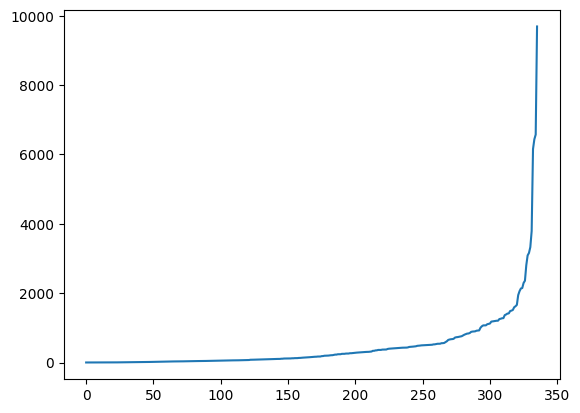

In [10]:
"""
This Code plotts the distribution of samples over different bird species
"""
import matplotlib.pyplot as plt
x = range(len(bird_samples))
y = []
for b,n in bird_samples.items():
    y.append(n)
y.sort()
plt.plot(x,y)

max_bird=max(bird_samples,key=bird_samples.get)
print(f"The most common class is {max_bird} with {bird_samples[max_bird]} samples")
min_bird=min(bird_samples,key=bird_samples.get)
print(f"The least common class is {min_bird} with {bird_samples[min_bird]} samples")

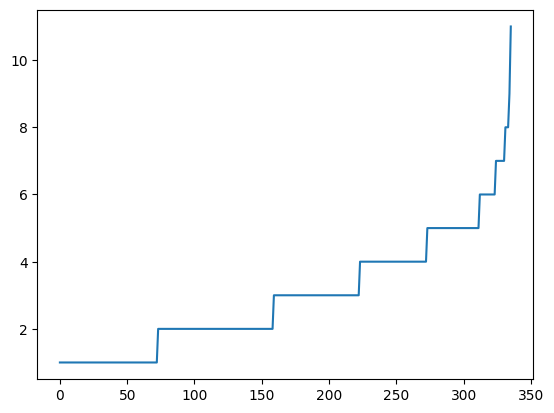

In [11]:
"""This Block plotss how many different call types each bird has"""

import matplotlib.pyplot as plt
x = range(len(call_types))
y = []
for bird,calls in call_types.items():
    y.append(len(calls))
y.sort()
plt.plot(x,y)

['f (Flugruf)', 'c (Kontaktruf)', 'ac (Alarmruf)', 's (Gesang)', 'wb (Fluegelschlag)', 'rs (Rufe am Schlafplatz)', 'b (Bettelruf)', 's2 (Zweitgesang)', 'nfc (Nachtzugruf)', 'u (Unidentified)', 'e (Erregungsruf)', 'ac_b (Alarmruf_Bodenfeinde)', 'ac_f (Alarmruf Luftfeinde)', 't (Trommeln)', 'nfc (Nachzugruf)']


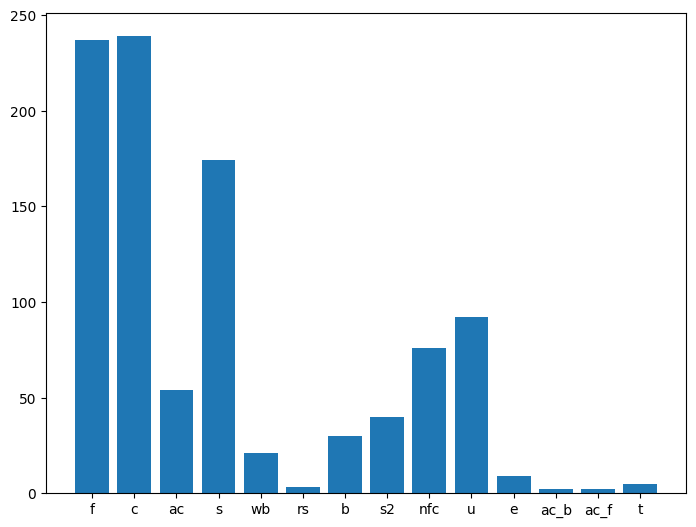

In [12]:
"""This Block plotts by how many species each call type is used"""
import re

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#x = [re.findall(r'\(.*?\)',c)[0] for c in all_call_types]
x = [re.findall(r'.*?\s',c)[0][:-1] for c in all_call_types]
print(all_call_types)
y = []
for call in all_call_types:
    c=0
    for bird,calls in call_types.items():
        if call in calls:
            c+=1
    y.append(c)

ax.bar(x,y)
plt.show()


In [16]:
"""Lets see how many bird species are shared between datasets"""

#dataset = zenodo
#dataset = oekofor

print(f"Zenodo has {len(zenodo['ID']):,} samples")
print(f"OekoFor has {len(oekofor['ID']):,} samples")

#count each bird occurence
zenodo_birds = {}
oekofor_birds = {}
#start the count at 0 for each bird
for bird in ebird_to_common.keys():
    zenodo_birds[bird]=0
    oekofor_birds[bird]=0
#count the birds
for bird in zenodo["Species eBird Code"]:
    zenodo_birds[bird]+=1
for bird in oekofor["Species eBird Code"]:
    oekofor_birds[bird]+=1
#delete birds with 0 occurences
zenodo_birds = {k: v for k, v in zenodo_birds.items() if v>0}
oekofor_birds = {k: v for k, v in oekofor_birds.items() if v>0}

shared_birds = {}
sum = 0
for bird, count in zenodo_birds.items():
    if bird in oekofor_birds.keys():
        shared_birds[bird]=zenodo_birds[bird]+oekofor_birds[bird]
        sum+=shared_birds[bird]

print(f"Oekofor and Zenodo share {len(shared_birds)} species")
print(f"This is a total of {sum} samples")

for key, value in shared_birds.items():
    print(f"The species {key} has {value} samples")

Zenodo has 155,584 samples
OekoFor has 157,661 samples
Oekofor and Zenodo share 9 species
This is a total of 17060 samples
The species cangoo has 2120 samples
The species tunswa has 24 samples
The species mallar3 has 975 samples
The species bcnher has 2295 samples
The species comrav has 580 samples
The species skylar has 4562 samples
The species eursta has 338 samples
The species amepip has 2372 samples
The species redcro has 3794 samples
